EfficientNetB0 model on the Melanoma Cancer Image Dataset

In [6]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Recall
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #no warnings


In [1]:
#Uploading the dataset
from google.colab import files
uploaded = files.upload()

Saving archive (1).zip to archive (1).zip


In [2]:
import zipfile
import os

os.makedirs('data', exist_ok=True)
with zipfile.ZipFile('archive (1).zip', 'r') as zip_ref:
    zip_ref.extractall('data')


In [3]:
train_dir = 'data/train'
test_dir = 'data/test'

In [4]:
# check total images in every map
train_benign = len(os.listdir(os.path.join(train_dir, 'Benign')))
train_malignant = len(os.listdir(os.path.join(train_dir, 'Malignant')))
test_benign = len(os.listdir(os.path.join(test_dir, 'Benign')))
test_malignant = len(os.listdir(os.path.join(test_dir, 'Malignant')))

print(f"Train Benign samples: {train_benign}")
print(f"Train Malignant samples: {train_malignant}")
print(f"Test Benign samples: {test_benign}")
print(f"Test Malignant samples: {test_malignant}")

Train Benign samples: 6289
Train Malignant samples: 5590
Test Benign samples: 1000
Test Malignant samples: 1000


In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 10692 images belonging to 2 classes.
Found 1187 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


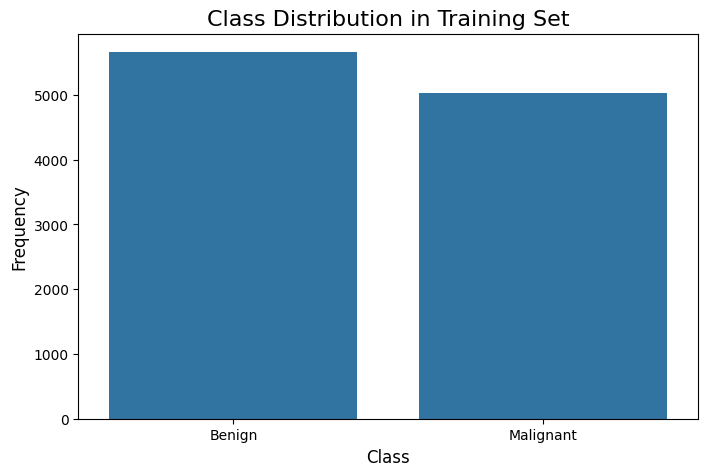

In [8]:
# Class distribution in training set
train_class_counts = [sum(train_generator.classes == i) for i in range(2)]
plt.figure(figsize=(8, 5))
sns.barplot(x=['Benign', 'Malignant'], y=train_class_counts)
plt.xlabel('Class', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Class Distribution in Training Set', size=16)
plt.show()

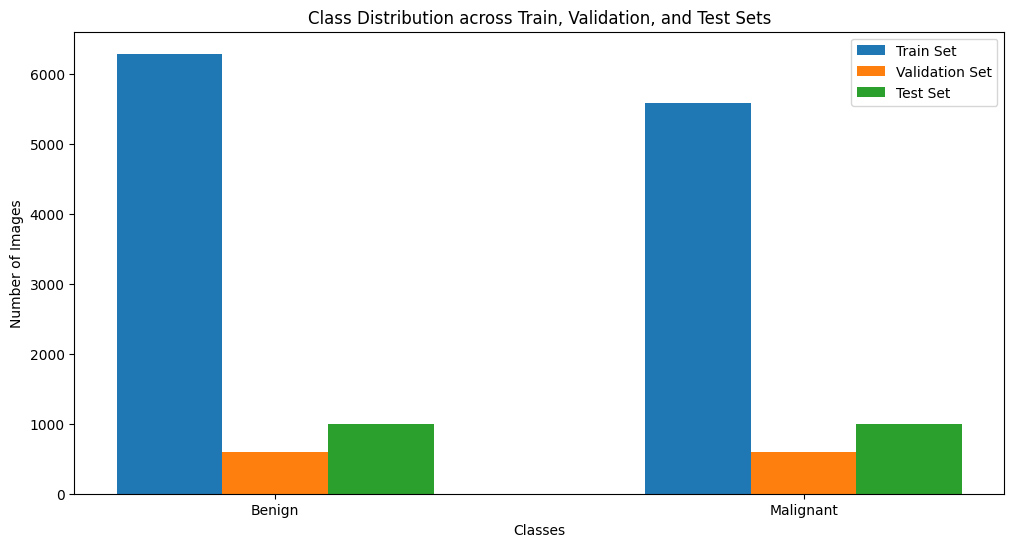

In [9]:
# Another Class distribution
train_class_counts = [train_benign_count, train_malignant_count]
validation_class_counts = [len(validation_generator.filenames) // 2, len(validation_generator.filenames) // 2]
test_class_counts = [len(test_generator.filenames) // 2, len(test_generator.filenames) // 2]

labels = ['Benign', 'Malignant']
x = range(len(labels))

plt.figure(figsize=(12, 6))
plt.bar(x, train_class_counts, width=0.2, label='Train Set', align='center')
plt.bar([p + 0.2 for p in x], validation_class_counts, width=0.2, label='Validation Set', align='center')
plt.bar([p + 0.4 for p in x], test_class_counts, width=0.2, label='Test Set', align='center')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks([p + 0.2 for p in x], labels)
plt.legend()
plt.title('Class Distribution across Train, Validation, and Test Sets')
plt.show()

In [10]:
# Model setup with EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='max')

# Custom layers on top of EfficientNetB0
x = base_model.output
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  

model = Model(inputs=base_model.input, outputs=output)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', Recall()])
"""
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('melanoma_classifier.keras', save_best_only=True)
]
"""
epochs = 15
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


335/335 ━━━━━━━━━━━━━━━━━━━━ 277s 584ms/step - accuracy: 0.7260 - loss: 1.2832 - recall: 0.7020 - val_accuracy: 0.4322 - val_loss: 17.7336 - val_recall: 0.8014
Epoch 2/15
335/335 ━━━━━━━━━━━━━━━━━━━━ 162s 430ms/step - accuracy: 0.8484 - loss: 0.5093 - recall: 0.8357 - val_accuracy: 0.5611 - val_loss: 1.2922 - val_recall: 0.1646
Epoch 3/15
335/335 ━━━━━━━━━━━━━━━━━━━━ 147s 429ms/step - accuracy: 0.8793 - loss: 0.3059 - recall: 0.8717 - val_accuracy: 0.7355 - val_loss: 0.4913 - val_recall: 0.6225
Epoch 4/15
335/335 ━━━━━━━━━━━━━━━━━━━━ 209s 450ms/step - accuracy: 0.8906 - loss: 0.2731 - recall: 0.8757 - val_accuracy: 0.7700 - val_loss: 0.4323 - val_recall: 0.7299
Epoch 5/15
335/335 ━━━━━━━━━━━━━━━━━━━━ 195s 431ms/step - accuracy: 0.8987 - loss: 0.2452 - recall: 0.8846 - val_accuracy: 0.7801 - val_loss: 0.4521 - val_recall: 0.8104
Epoch 6/15
335/335 ━━━━━━━━━━━━━━━━━━━━ 208s 451ms/step - accuracy: 0.9052 - loss: 0.2329 - recall: 0.8909 - val_accuracy: 0.7885 - val_loss: 0.4159 - val_recal

In [12]:
# Evaluation on test data
loss, accuracy, recall = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Test Recall: {recall * 100:.2f}%')
print(f'Test Loss: {loss}')


63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9458 - loss: 0.1533 - recall: 0.4749
Test Accuracy: 92.35%
Test Recall: 89.90%
Test Loss: 0.1994122713804245


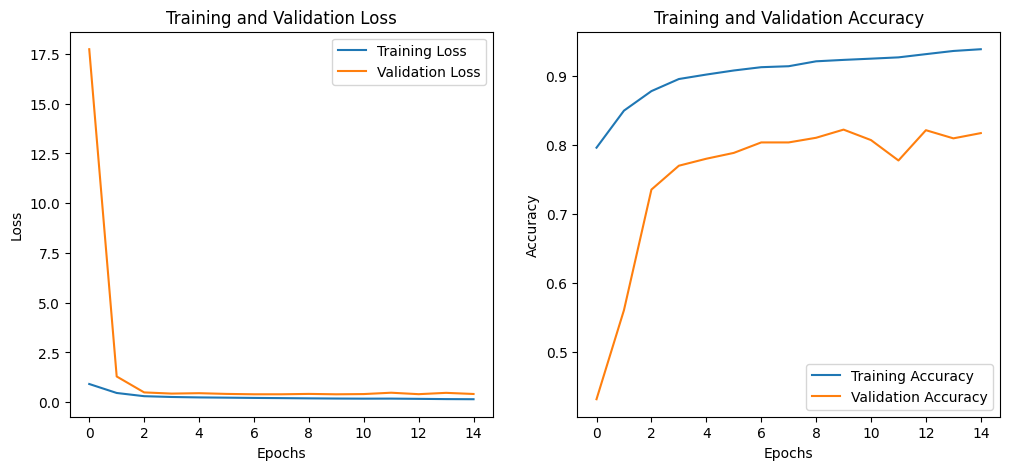

63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step


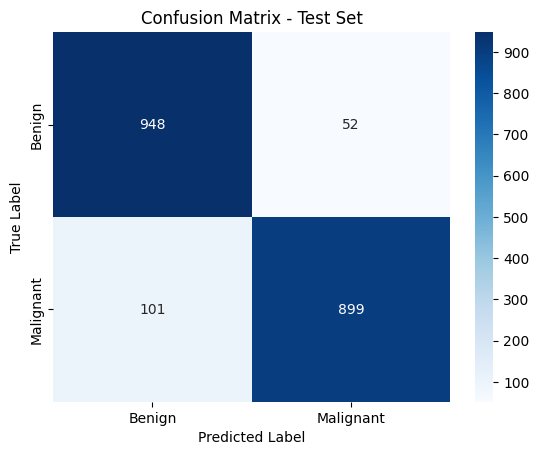

Classification Report:
               precision    recall  f1-score   support

      Benign       0.90      0.95      0.93      1000
   Malignant       0.95      0.90      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



In [13]:
# Plotting training and validation metrics
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
from sklearn.metrics import confusion_matrix, classification_report

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Confusion matrix on test data
test_labels = test_generator.classes
test_preds = (model.predict(test_generator) > 0.5).astype("int32")

conf_matrix = confusion_matrix(test_labels, test_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification report
print("Classification Report:\n", classification_report(test_labels, test_preds, target_names=test_generator.class_indices.keys()))

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step


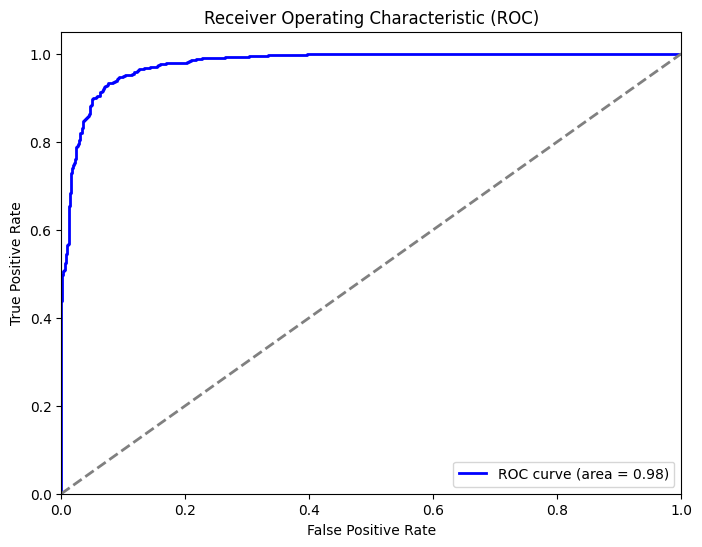

AUC score: 0.98


In [14]:
# ROC and AUC 
y_pred_prob = model.predict(test_generator)
y_true = test_generator.classes  

fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC-curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--') 
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print(f'AUC score: {roc_auc:.2f}')

In [16]:
#saving the model 
model.save('EfficientNetklopt_melanoma.keras')

In [17]:
#saving the model 
model.save('EfficientNetklopt_melanoma.h5')

In [ ]:
#download model
from google.colab import files
files.download('EfficientNetklopt_melanoma.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
#download model
from google.colab import files
files.download('EfficientNetklopt_melanoma.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#

#
EfficientNetB0 model on the filtered HAM10000 dataset

In [19]:
#import libraries again (if needed)
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import json
import seaborn as sns

In [ ]:
#uploading the trained EfficientNetB0 model (if needed)
from google.colab import files
uploaded = files.upload()

Saving EfficientNet_melanoma.h5 to EfficientNet_melanoma.h5


In [20]:
model_path = '/content/EfficientNetklopt_melanoma.h5' 
model = tf.keras.models.load_model(model_path)
print("Model geladen van:", model_path)

Model geladen van: /content/EfficientNetklopt_melanoma.h5


In [21]:
#mount Drive for the filtered HAM10000 dataset 
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# if needed, upload the filtered dataset,if you don't want to use google drive

#from google.colab import files
#uploaded = files.upload()  # Select dataset.zip file


In [ ]:
#test_dir = '/content/data/HAM10000_balanced_nv_mel_equal_gender'
#metadata_file = '/content/data/HAM10000_balanced_nv_mel_equal_gender/HAM10000_filtered_metadata.csv'


In [22]:
test_dir = '/content/drive/My Drive/kaggle/HAM10000_balanced_nv_mel_equal_gender'
metadata_file = '/content/drive/My Drive/kaggle/HAM10000_balanced_nv_mel_equal_gender/HAM10000_filtered_metadata.csv'


In [23]:
# check files
print(os.path.exists(test_dir))
print(os.path.exists(metadata_file))

# Load metadata
metadata = pd.read_csv(metadata_file)
print(metadata.head())

True
True
     lesion_id      image_id  dx    dx_type   age     sex localization
0  HAM_0002056  ISIC_0026762  nv  follow_up  55.0  female        trunk
1  HAM_0004149  ISIC_0032755  nv      histo  45.0  female         foot
2  HAM_0002663  ISIC_0030720  nv  follow_up  35.0  female        trunk
3  HAM_0001502  ISIC_0027482  nv  follow_up  55.0  female      abdomen
4  HAM_0005017  ISIC_0027461  nv      histo  75.0  female         back


In [24]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 1696 images belonging to 2 classes.


In [36]:
#evaluation on this filtered dataset
results = model.evaluate(test_generator)
print("Evaluation Results:", results)

53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 340ms/step - accuracy: 0.8796 - loss: 0.2935 - recall: 0.3119
Evaluation Results: [0.4957024157047272, 0.7936320900917053, 0.6792452931404114]


In [37]:
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")
print(f"Test Recall: {results[2]}")

Test Loss: 0.4957024157047272
Test Accuracy: 0.7936320900917053
Test Recall: 0.6792452931404114


In [27]:
y_true = test_generator.classes 
y_pred_proba = model.predict(test_generator).ravel() 
y_pred = (y_pred_proba > 0.5).astype("int32") 

# 7. Confusionmatrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# 8. Classification rapport 
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 322ms/step
Confusion Matrix:
 [[770  78]
 [272 576]]
Classification Report:
               precision    recall  f1-score   support

      Benign       0.74      0.91      0.81       848
   Malignant       0.88      0.68      0.77       848

    accuracy                           0.79      1696
   macro avg       0.81      0.79      0.79      1696
weighted avg       0.81      0.79      0.79      1696



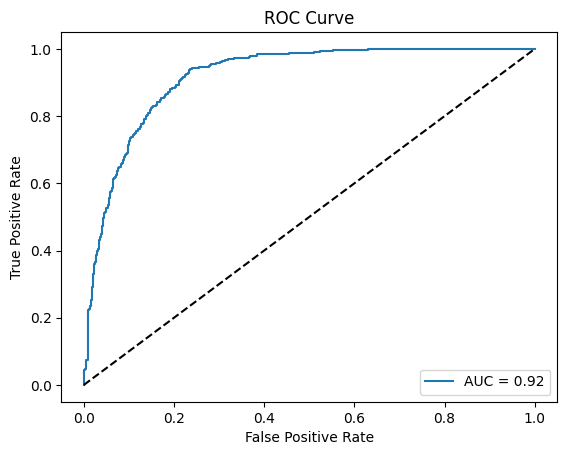

AUC-ROC: 0.92


In [31]:
# 9. AUC-ROC curve
roc_auc = roc_auc_score(y_true, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
print(f"AUC-ROC: {roc_auc:.2f}")

In [32]:
# Gender (male and female) performance
# Load metadata
metadata = pd.read_csv(metadata_file)
metadata['true_labels'] = metadata['dx'].map({'nv': 0, 'mel': 1})  
metadata['predictions'] = y_pred  

# performance for gender
results_by_gender = {}
for gender in ['male', 'female']:
    gender_data = metadata[metadata['sex'] == gender]
    true_labels = gender_data['true_labels']
    predictions = gender_data['predictions']

    # Confusionmatrix and classification rapport
    conf_matrix = confusion_matrix(true_labels, predictions)
    report = classification_report(true_labels, predictions, target_names=['Benign', 'Malignant'], output_dict=True)

    results_by_gender[gender] = {
        'confusion_matrix': conf_matrix,
        'classification_report': report
    }
    print(f"\nPerformance for {gender.capitalize()} Patients:")
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", classification_report(true_labels, predictions, target_names=['Benign', 'Malignant']))


Performance for Male Patients:
Confusion Matrix:
 [[364  60]
 [ 93 331]]
Classification Report:
               precision    recall  f1-score   support

      Benign       0.80      0.86      0.83       424
   Malignant       0.85      0.78      0.81       424

    accuracy                           0.82       848
   macro avg       0.82      0.82      0.82       848
weighted avg       0.82      0.82      0.82       848


Performance for Female Patients:
Confusion Matrix:
 [[406  18]
 [179 245]]
Classification Report:
               precision    recall  f1-score   support

      Benign       0.69      0.96      0.80       424
   Malignant       0.93      0.58      0.71       424

    accuracy                           0.77       848
   macro avg       0.81      0.77      0.76       848
weighted avg       0.81      0.77      0.76       848



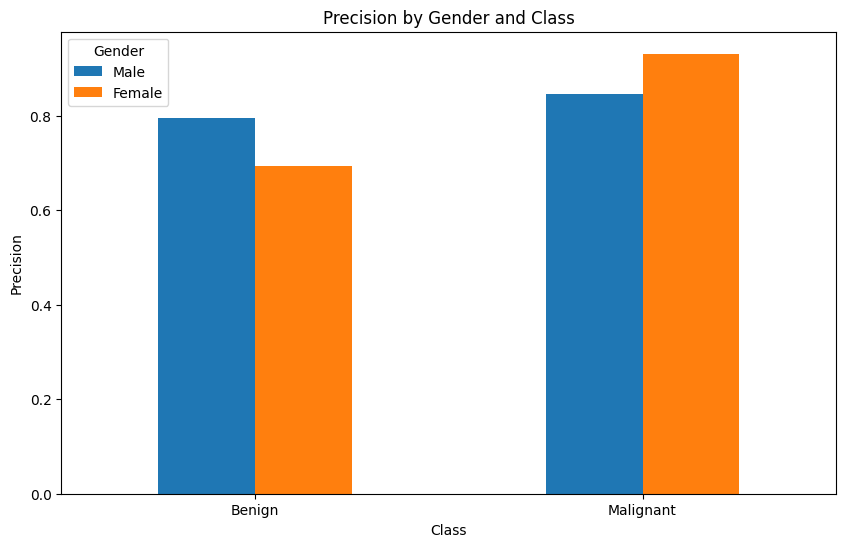

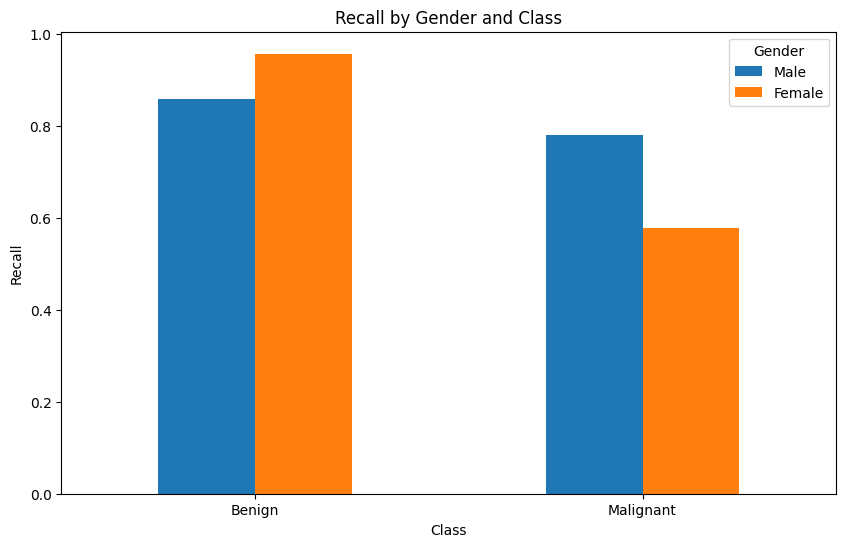

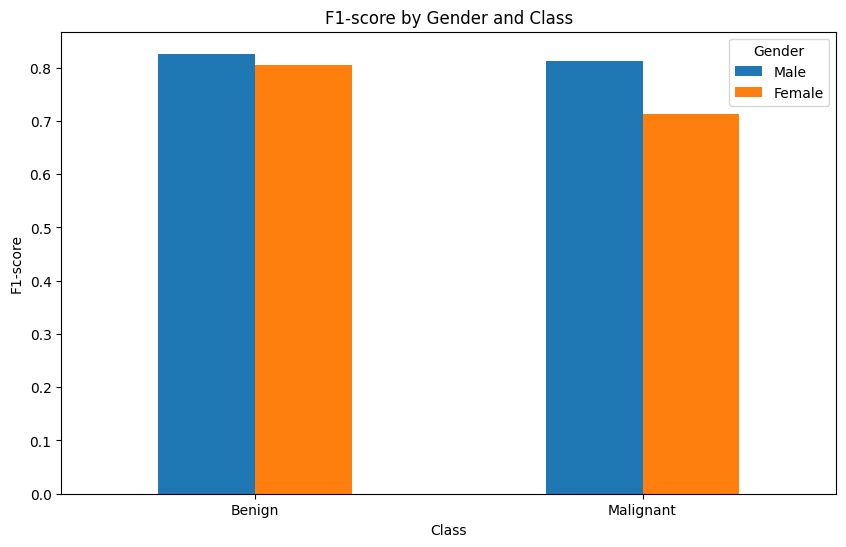

In [33]:
# Plots for quick overview
metrics = ['precision', 'recall', 'f1-score']
classes = ['Benign', 'Malignant']
gender_metrics = {metric: {gender: [] for gender in ['male', 'female']} for metric in metrics}

for gender in results_by_gender:
    for metric in metrics:
        for cls in classes:
            gender_metrics[metric][gender].append(results_by_gender[gender]['classification_report'][cls][metric])

# Plot per metric
for metric in metrics:
    data = pd.DataFrame(gender_metrics[metric], index=classes)
    data.plot(kind='bar', figsize=(10, 6))
    plt.title(f"{metric.capitalize()} by Gender and Class")
    plt.ylabel(metric.capitalize())
    plt.xlabel("Class")
    plt.xticks(rotation=0)
    plt.legend(title="Gender", labels=['Male', 'Female'])
    plt.show()

In [34]:
for gender in ['male', 'female']:
    gender_data = metadata[metadata['sex'] == gender]
    true_labels = gender_data['true_labels'].values
    predictions = gender_data['predictions'].values
    probabilities = y_pred_proba[gender_data.index]  

    # AUC-ROC
    auc_score = roc_auc_score(true_labels, probabilities)
    fpr, tpr, thresholds = roc_curve(true_labels, probabilities)
    print(f"AUC for {gender.capitalize()} Patients: {auc_score:.2f}")

AUC for Male Patients: 0.91
AUC for Female Patients: 0.94



Confusion Matrix for Male Patients:
[[364  60]
 [ 93 331]]
AUC for Male Patients: 0.91


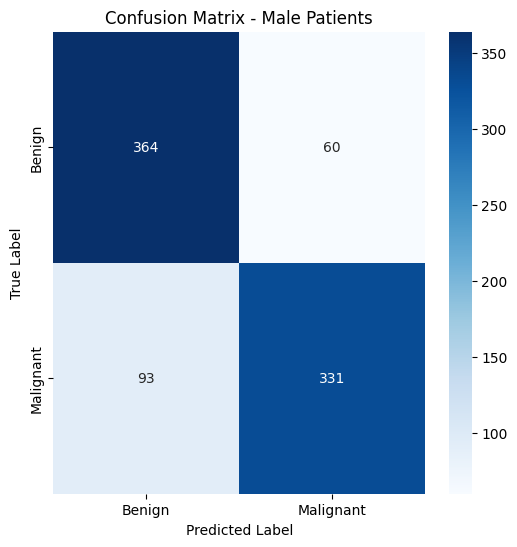

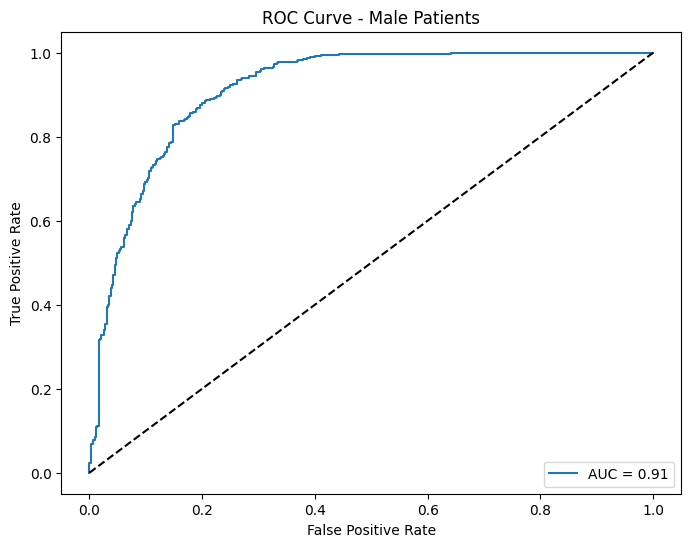


Confusion Matrix for Female Patients:
[[406  18]
 [179 245]]
AUC for Female Patients: 0.94


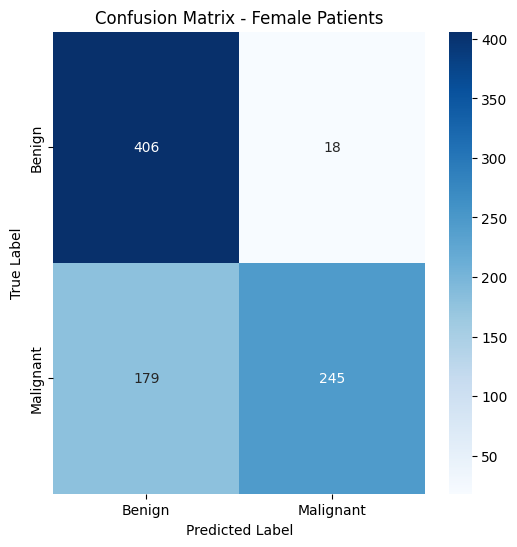

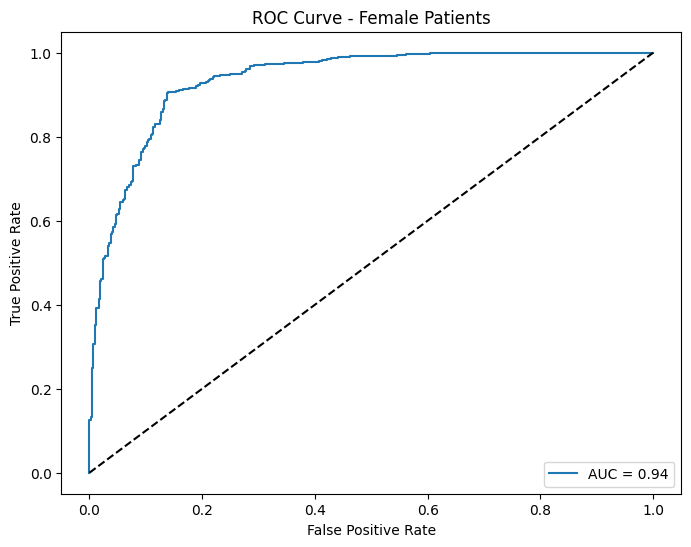

In [35]:
# Gender performance with small and big confusion matrix and AUC-ROC score
for gender in ['male', 'female']:
    gender_data = metadata[metadata['sex'] == gender]
    true_labels = gender_data['true_labels'].values
    predictions = gender_data['predictions'].values
    probabilities = y_pred_proba[gender_data.index] 
    
    # Confusion Matrix
    conf_matrix_gender = confusion_matrix(true_labels, predictions)
    print(f"\nConfusion Matrix for {gender.capitalize()} Patients:")
    print(conf_matrix_gender)

    # AUC-ROC
    auc_score = roc_auc_score(true_labels, probabilities)
    fpr, tpr, thresholds = roc_curve(true_labels, probabilities)
    print(f"AUC for {gender.capitalize()} Patients: {auc_score:.2f}")

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix_gender, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.title(f"Confusion Matrix - {gender.capitalize()} Patients")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')  
    plt.title(f"ROC Curve - {gender.capitalize()} Patients")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()